In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Aditya1Jhaveri/cervix-cancer-Deep-learning.git

Cloning into 'cervix-cancer-Deep-learning'...
remote: Enumerating objects: 53268, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 53268 (delta 4), reused 33 (delta 3), pack-reused 53234
Receiving objects: 100% (53268/53268), 1.75 GiB | 38.89 MiB/s, done.
Resolving deltas: 100% (210/210), done.
Updating files: 100% (50894/50894), done.


In [3]:
import tensorflow as tf
from keras.applications import Xception
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,Flatten
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
from keras.utils import to_categorical



# Set your data directories and parameters
train_data_dir = '/content/cervix-cancer-Deep-learning/NEW_DATASET/train'
test_data_dir = '/content/cervix-cancer-Deep-learning/NEW_DATASET/test'
val_data_dir = '/content/cervix-cancer-Deep-learning/NEW_DATASET/validation'


img_width, img_height = 224, 224
batch_size = 16
base_learning_rate = 0.001  # Adjust as needed

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Data preprocessing for test
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Load the data using data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=True  # Shuffle the data
)
print(f"Found {train_generator.samples} images belonging to {len(train_generator.class_indices)} classes in train dataset.")

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=False  # No need to shuffle test data
)
print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes in test dataset.")

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=False  # No need to shuffle test data
)
print(f"Found {val_generator.samples} images belonging to {len(val_generator.class_indices)} classes in validation dataset.")


Found 12110 images belonging to 7 classes.
Found 12110 images belonging to 7 classes in train dataset.
Found 2083 images belonging to 7 classes.
Found 2083 images belonging to 7 classes in test dataset.
Found 3111 images belonging to 7 classes.
Found 3111 images belonging to 7 classes in validation dataset.


In [4]:
# Load the Xception model
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


# Add your custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block13_sepconv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)


83683744/83683744 [==============================] - 1s 0us/step
input_1 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d False
block2_pool False
batch_normalization False
add False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_1 False
block3_pool False
batch_normalization_1 False
add_1 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_2 False
block4_pool False
batch_normalization_2 False
add_2 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act Fa

In [ ]:
model.summary();

In [5]:
# Compile the model after unfreezing layers for fine-tuning
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Use categorical_crossentropy
    optimizer=RMSprop(learning_rate=base_learning_rate/10),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]  # Use CategoricalAccuracy
)

# Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate reduction
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=25,
    validation_data=val_generator,
    validation_steps=len(val_generator) // batch_size,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
756/756 [==============================] - 244s 293ms/step - loss: 1.1301 - accuracy: 0.5562 - val_loss: 0.4469 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 2/25
756/756 [==============================] - 202s 267ms/step - loss: 0.7804 - accuracy: 0.6969 - val_loss: 0.8753 - val_accuracy: 0.6719 - lr: 1.0000e-04
Epoch 3/25
756/756 [==============================] - 201s 266ms/step - loss: 0.6683 - accuracy: 0.7451 - val_loss: 0.4884 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 4/25
756/756 [==============================] - 200s 265ms/step - loss: 0.5867 - accuracy: 0.7744 - val_loss: 0.6281 - val_accuracy: 0.7448 - lr: 1.0000e-04
Epoch 5/25
756/756 [==============================] - 199s 263ms/step - loss: 0.5205 - accuracy: 0.8043 - val_loss: 0.6721 - val_accuracy: 0.7344 - lr: 1.0000e-04
Epoch 6/25
756/756 [==============================] - 200s 265ms/step - loss: 0.4539 - accuracy: 0.8317 - val_loss: 0.6860 - val_accuracy: 0.7344 - lr: 1.0000e-04
Epoch 7/25
756/756 [==

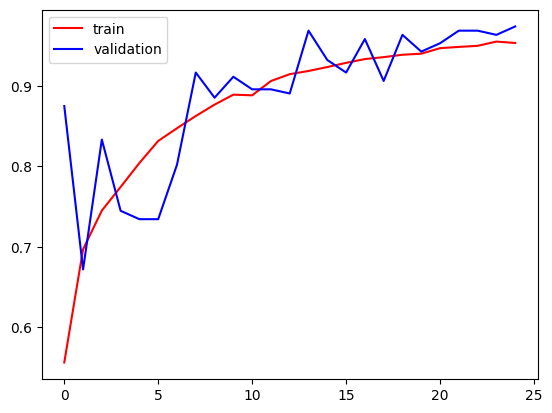

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [7]:
train_loss, train_accuracy = model.evaluate(train_generator)

print(f'Train accuracy: {train_accuracy:.4f}')

757/757 [==============================] - 222s 293ms/step - loss: 0.0643 - accuracy: 0.9780
Train accuracy: 0.9780


In [8]:
# Evaluate the model on the test data using the test generator
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy:.4f}')

131/131 [==============================] - 36s 273ms/step - loss: 0.1132 - accuracy: 0.9592
Test accuracy: 0.9592


131/131 [==============================] - 33s 250ms/step


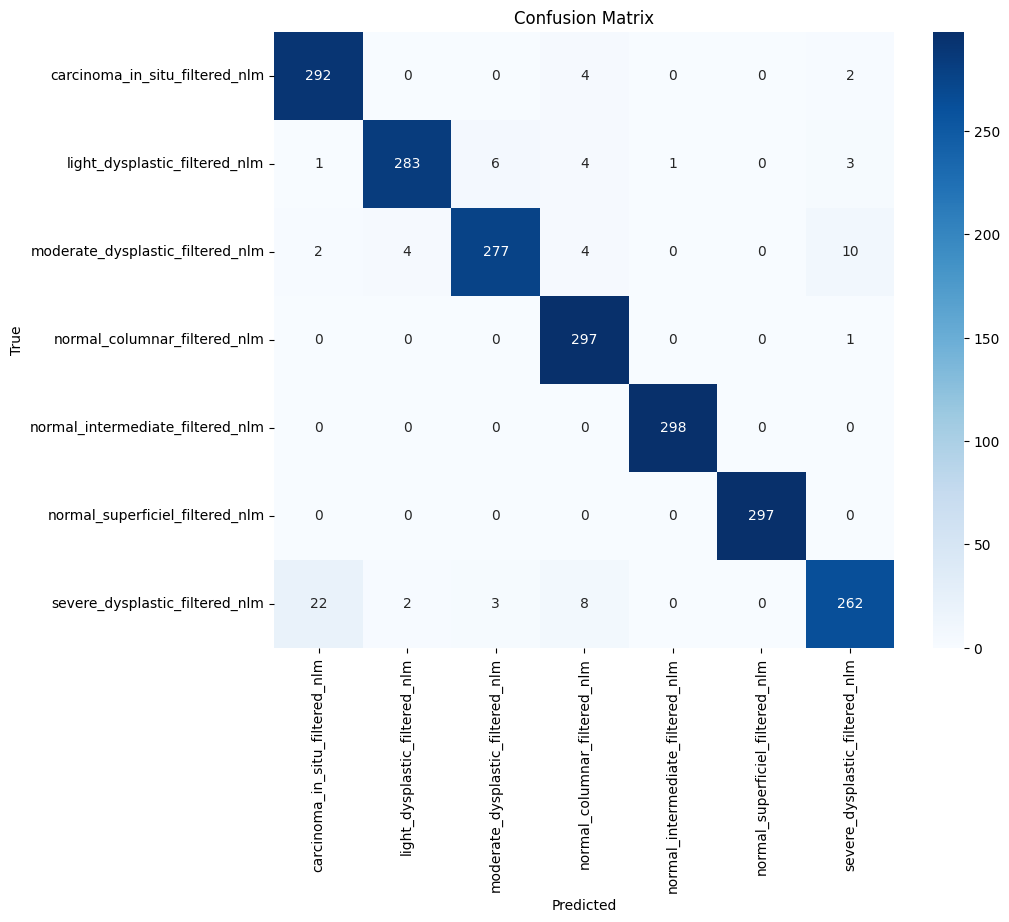

                              Class  Precision    Recall  F1 Score
0    carcinoma_in_situ_filtered_nlm   0.921136  0.979866  0.949593
1     light_dysplastic_filtered_nlm   0.979239  0.949664  0.964225
2  moderate_dysplastic_filtered_nlm   0.968531  0.932660  0.950257
3      normal_columnar_filtered_nlm   0.936909  0.996644  0.965854
4  normal_intermediate_filtered_nlm   0.996656  1.000000  0.998325
5   normal_superficiel_filtered_nlm   1.000000  1.000000  1.000000
6    severe_dysplastic_filtered_nlm   0.942446  0.882155  0.911304


In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred = model.predict(test_generator)

# Convert Predictions and True Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Create the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create a dictionary to map class indices to class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)


In [10]:
# Save the model with custom layers and weights
model.save('XceptionNet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from keras.applications import ResNet50V2

# Load the model
new_model = tf.keras.models.load_model('/content/InceptionV3.h5')

# Compile the model after unfreezing layers for fine-tuning
# new_model.compile(
#     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Use categorical_crossentropy
#     optimizer=RMSprop(learning_rate=base_learning_rate/10),
#     metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]  # Use CategoricalAccuracy
# )

# # Set up callbacks
# reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, min_lr=1e-6)
# early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# # Train the new_model with early stopping and learning rate reduction
# history = new_model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=50,
#     initial_epoch=25,
#     validation_data=val_generator,
#     validation_steps=len(val_generator) // batch_size,
#     callbacks=[reduce_lr, early_stopping]
# )


In [ ]:
train_loss, train_accuracy = new_model.evaluate(train_generator)

print(f'Train accuracy: {train_accuracy:.4f}')

In [ ]:
# Evaluate the model on the test data using the test generator
test_loss, test_accuracy = new_model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy:.4f}')

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred = new_model.predict(test_generator)

# Convert Predictions and True Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Create the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create a dictionary to map class indices to class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)


In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define the determine_cancerous function
def determine_cancerous(class_name):
    cancerous_classes = {
        'carcinoma_in_situ_filtered_nlm': True,
        'light_dysplastic_filtered_nlm': True,
        'moderate_dysplastic_filtered_nlm': True,
        'normal_columnar_filtered_nlm': False,
        'normal_intermediate_filtered_nlm':False,
        'normal_superficiel_filtered_nlm': False,
        'severe_dysplastic_filtered_nlm': True,
    }

    return cancerous_classes.get(class_name, None)

# Load and preprocess a sample image
image_path = '/content/cervix-cancer-Deep-learning/Herlev Dataset resized/test/normal_superficiel/157183412-157183638-001 - Copy (2).BMP'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # rescale

# Make a prediction
prediction = new_model.predict(img_array)

# Convert the prediction to class name
class_index = np.argmax(prediction)
class_name = list(test_generator.class_indices.keys())[class_index]

plt.imshow(img)
plt.show()

# Print the predicted class name
print(f'Predicted Class: {class_name}')

# Determine if it's cancerous or not
is_cancerous = determine_cancerous(class_name)



# Print whether it's cancerous or not
if is_cancerous is not None:
    if is_cancerous:
        print('Cancerous')
    else:
        print('Non-cancerous')
else:
    print('Class not found in dictionary')


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the NLM filter function
def nlm_filter(image):
    filtered_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)  # Adjust parameters as needed
    return filtered_image


# Define the determine_cancerous function
def determine_cancerous(class_name):
    cancerous_classes = {
        'carcinoma_in_situ_filtered_nlm': True,
        'light_dysplastic_filtered_nlm': True,
        'moderate_dysplastic_filtered_nlm': True,
        'normal_columnar_filtered_nlm': False,
        'normal_intermediate_filtered_nlm': False,
        'normal_superficiel_filtered_nlm': False,
        'severe_dysplastic_filtered_nlm': True,
    }
    return cancerous_classes.get(class_name, None)

# Load and preprocess a sample image
image_path = '/content/cervix-cancer-Deep-learning/Herlev Dataset resized/test/normal_superficiel/157222737-157222750-002 - Copy (2).BMP'  # Replace with the actual path to your image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB


filtered_image = nlm_filter(img_rgb)

# Display the filtered image
plt.imshow(filtered_image)
# plt.title('Filtered Image')
plt.show()

# Rescale and expand dimensions
img_array = np.expand_dims(filtered_image / 255., axis=0)

# Make a prediction
prediction = new_model.predict(img_array)

# Convert the prediction to class name
class_index = np.argmax(prediction)
class_name = list(test_generator.class_indices.keys())[class_index]

# Print the predicted class name
print(f'Predicted Class: {class_name}')

# Determine if it's cancerous or not
is_cancerous = determine_cancerous(class_name)

# Print whether it's cancerous or not
if is_cancerous is not None:
    if is_cancerous:
        print('Cancerous')
    else:
        print('Non-cancerous')
else:
    print('Class not found in dictionary')
